# 二叉树系列三

二叉树中的回溯

给定一个二叉树，返回所有从根节点到叶子节点的路径。

说明: 叶子节点是指没有子节点的节点。

示例 1：

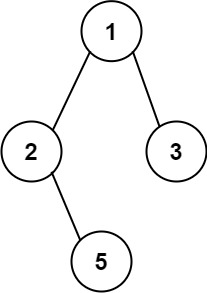

输入：root = [1,2,3,null,5]
输出：["1->2->5","1->3"]
示例 2：

输入：root = [1]
输出：["1"]


## 版本A（字符串 `str`，隐式回溯）

> 关键点：**字符串是不可变的**。`path += "->"` 等价于 `path = path + "->"` —— 会创建**新字符串对象**并把**当前函数帧里的**`path` 重新绑定到它；**上层/其它栈帧的 `path` 不变**。
> 因而**不需要手动撤销（pop）**，回溯“自动发生”——这就叫**回溯被隐藏**了。

```python
# 版本A：用字符串，不需要手动回溯（回溯被“隐藏”在不可变对象的重新绑定里）
class Solution:
    def binaryTreePaths(self, root):
        result = []
        self.dfs(root, "", result)
        return result

    def dfs(self, node, path, result):
        if not node:
            return

        # [1] 进入节点，尝试“做选择”：把当前节点值放到路径末尾。
        #     对字符串来说，这会生成一个新字符串对象，并把“当前栈帧”的 path 绑定到新对象。
        #     上一层传进来的 path 本身并不会被修改。
        path += str(node.val)  # === path = path + str(node.val)

        # [2] 到叶子：收割答案。此处没有共享可变状态，因此不需要撤销任何修改。
        if not node.left and not node.right:
            result.append(path)
        else:
            # [3] 继续深入左右子树前，为子调用准备"->"。
            #     注意：下面两句会把“当前帧”的 path 重新绑定到一个
            #     带箭头的新字符串对象（仍是不可变），
            #     但这种重新绑定不会影响“父帧”的 path 值。
            #     这就是“隐式回溯”：子调用返回后，父帧的 path 还是原来的。
            path += "->"  # === path = path + "->"

            # [隐式回溯点]：把“当前帧”的（新）path 传给左子树。
            self.dfs(node.left, path, result)

            # [隐式回溯点]：左子树返回后，这一帧中的 path 仍是“加了 -> 的字符串”，
            # 继续把它传给右子树。注意，这里并不需要把 "->" 去掉，因为父/祖先帧各自有自己的 path 拷贝。
            self.dfs(node.right, path, result)

        # [4] 返回上一层：不需要写任何“撤销”代码，因为字符串不可变 + 每一层有自己的局部绑定。
        #     这一点就是“回溯被隐藏了”的本质。
```

**为什么说这是“回溯”？**
回溯的本质是：**在离开当前分支时，把“共享/可见的状态”恢复到进入分支前的样子**。
在上面这版里，“状态”（`path`）每一层都是**独立的新字符串对象**，离开本层时，上层的 `path` 天然没被改动，所以**看起来不需要恢复**，但**效果上等价于已经恢复**了——因此说“回溯被隐藏了”。

---

## 版本B（列表 `list`，显式回溯）

> 关键点：**列表是可变的**，各层递归**共享同一份对象**。你在子调用里 `append` 了，返回给兄弟分支之前**必须 `pop` 撤销**——这一步就是**显式回溯**。

```python
# 版本B：用列表（可变对象），需要手动回溯（pop）
class Solution:
    def binaryTreePaths(self, root):
        res, path = [], []

        def dfs(node):
            if not node:
                return
            path.append(str(node.val))         # 做选择
            if not node.left and not node.right:
                res.append("->".join(path))    # 到叶子：直接拼好存结果（省内存/省一次遍历）
            else:
                dfs(node.left)
                dfs(node.right)
            path.pop()                         # 回溯（撤销本层选择）

        dfs(root)
        return res
```

---

## 小例子走一遍（树：`[1,2,3,null,5]`）

```
    1
   / \
  2   3
   \
    5
```

### 在版本A（字符串）里

* 入 1：`path="" -> "1"`

  * 走左（传 `"1->"`）：入 2：`"1->2"`

    * 走右（传 `"1->2->"`）：入 5：`"1->2->5"`（叶）→ 记 `"1->2->5"`，返回
  * 走右（传 `"1->"`）：入 3：`"1->3"`（叶）→ 记 `"1->3"`，返回
* 注意：整个过程中**没有手动撤销**。因为每一层的 `path` 都是**它自己的新字符串**，返回以后**上层变量保持原状**（这就是“隐式回溯”）。

### 在版本B（列表）里

* 入 1：`path = [] -> ["1"]`

  * 走左：`["1", "2"]`

    * 走右：`["1", "2", "5"]`（叶）→ 记 `["1","2","5"]` 的拷贝
    * 返回到 2：**回溯** `pop()`，从 `["1","2","5"]` → `["1","2"]`
  * 返回到 1：**回溯** `pop()`，从 `["1","2"]` → `["1"]`
  * 走右：`["1","3"]`（叶）→ 记拷贝
  * 返回到 1：**回溯** `pop()`，从 `["1","3"]` → `[]`
* 没有这些 `pop()`，路径会被“污染”，要么结果错，要么所有叶子都指向同一对象。